In [ ]:
import numpy as np

from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

np.random.seed(42)

%load_ext autoreload
%autoreload 2

%matplotlib inline

### Generate data

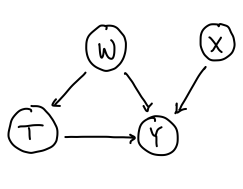

In [ ]:
def make_data(n, n_w = 20, informative = 5):
    assert informative < n_w, "number of informative features cannot exceed number of features"
    
    W = np.random.normal(0,1,size=(n,n_w))
    X = np.random.uniform(0,1,size=(n))
    
    # dependence of T on W
    coef_T = np.zeros(n_w)
    coef_T[0:informative] = np.random.uniform(size=informative)
    log_odds = W@coef_T
    p = 1/(1 + np.exp(-log_odds))
    T = np.random.binomial(1,p)
    
    # Treatment effect dependence on X
    def TE(X):
        return X
    
    # dependence of Y on T, W and X
    coef_Y = np.zeros(n_w)
    coef_Y[0:informative] = np.random.uniform(size=informative)
    Y = TE(X)*T + W@coef_Y + np.random.uniform(-1,1,size=n)
    
    return {'W':W,'X':X,'T':T,'Y':Y}, TE
    
        
data, treatment_effect = make_data(1000)
X, W, T, Y = data['X'].reshape(-1,1), data['W'], data['T'], data['Y']

V = np.hstack((X,W)) # for models that don't distinguish between them

print("Treatment effect on sample:",treatment_effect(X).mean())

### DROrthoForest

In [ ]:
def make_orthoforest():
    est = DROrthoForest(
        n_trees=200, min_leaf_size=10,
        max_depth=30, subsample_ratio=0.5,
        propensity_model = LogisticRegression(penalty='l1', solver='saga'),
        model_Y = Lasso(),
        propensity_model_final=LogisticRegression(penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(),
        random_state=123,
        
    )
    return est

est = make_orthoforest()
est.fit(Y, T,X=X,W=W)
est.ate(X = X), est.ate_interval(X=X)

In [ ]:
est  = make_orthoforest()
est.fit(Y, T, X=V)
est.ate(X=V),est.ate_interval(X=V)

### CausalForestDML

In [ ]:
est2 = CausalForestDML(model_y=Lasso(),
                       model_t=LogisticRegression(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       discrete_treatment=True,
                       random_state=123)
est2.fit(Y, T, X=X, W=W)
est2.ate(X=X), est2.ate_interval(X=X)

In [ ]:
est3 = CausalForestDML(model_y=Lasso(),
                       model_t=LogisticRegression(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       discrete_treatment=True,
                       random_state=123)
est3.fit(Y, T, X=V)
est3.ate(X=V), est2.ate_interval(X=V)

### LinearDML

In [ ]:
from econml.dml import LinearDML
est4 = LinearDML(discrete_treatment=True)
est4.fit(Y,T,X=X,W=W)
est4.ate(X=X), est4.ate_interval(X=X)

### LinearDRLearner

In [ ]:
from econml.dr import LinearDRLearner
est5 = LinearDRLearner()
est5.fit(Y,T,X=X,W=W)
est5.ate(X=X), est5.ate_interval(X=X)

### DRLearner


In [ ]:
from econml.dr import DRLearner
est6 = DRLearner()
est6.fit(Y,T,X=X,W=W)
est6.ate(X=X), est6.ate_interval(X=X)

### Meta Learner (T-learner)

In [ ]:
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
models = GradientBoostingRegressor()
est_t = TLearner(models=models)
est_t.fit(Y, T, X=V, inference='bootstrap')
est_t.ate(X=V), est_t.ate_interval(X=V)

In [ ]:
models = LinearRegression()
est_t = TLearner(models=models)
est_t.fit(Y, T, X=V, inference='bootstrap')
est_t.ate(X=V), est_t.ate_interval(X=V)

### Manual T-Learner

In [ ]:
model0 = LinearRegression()
model1 = LinearRegression()

V0 = V[T==0]
V1 = V[T==1]
y0 = Y[T==0]
y1 = Y[T==1]

print("Data dimensions:",V0.shape, len(y0), V1.shape, len(y1))

model0.fit(V0,y0)
model1.fit(V1,y1)
ate = (model1.predict(V) - model0.predict(V)).mean()
ate